<a href="https://colab.research.google.com/github/harnalashok/general/blob/master/ta_feng_grocery_stores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
%matplotlib inline

In [ ]:
"""
Last amended: 26th May, 2022
My folder: /home/ashok/Documents/ta_feng_grocerystore
           C:\Users\ashok\OneDrive\Documents\Ta Feng Grocery Datasets

Ref:
     https://pandas.pydata.org/pandas-docs/stable/cookbook.html#cookbook-grouping
     https://pandas.pydata.org/pandas-docs/stable/groupby.html

####################################################################3
# Ta Feng Grocery dataset
# Data Source: http://stackoverflow.com/questions/25014904/download-link-for-ta-feng-grocery-dataset
#	Other grocery datasets:
#		https://sites.google.com/a/dlpage.phi-integration.com/pentaho/mondrian/mysql-foodmart-database/foodmart_mysql.tar.gz?attredirects=0
#		http://recsyswiki.com/wiki/Grocery_shopping_datasets
# References on clustering/customer segmentation or on kohonen SOM:
# 		1. https://cran.r-project.org/web/views/Cluster.html
#   	2. http://www.shanelynn.ie/self-organising-maps-for-customer-segmentation-using-r/
#		3. General on kohonen: https://dzone.com/articles/self-organizing-maps
#		4. http://www.slideshare.net/jonsedar/customer-clustering-for-marketing
#
####################################################################

# Objectives:
            1. Reducing dataframe memory
            2. Understand customer behaviour (using pandas groupby)
            3. Chi-square Tests and mosaic plot
            4. t-test of means
            5. Feature Engineering

 ----Customer Behaviour----
 For  every customer (unique customerid)
	  Record his first purchase date
	  Record his last purchase date
	  Which customers purchase just one-time
	  Who are repeat purchasers	or who have visited more than once
	  Record every customers total purchases
	  Record every customers average purchases
	  Record his basket of purchases: Variety of goods he purchases
   Per visit/per transaction min. max items purchased and avg money spent
 For your store:
	  What is the distribution of customers age-wise?
	  What is the distribution of age, res-area-wise
	  Age wise what is the average purchase basket
   Is there age preference for a particular product sub-class
 For a product-subclass
	  Which product-subclass brings most revenue
   Which productids are most popular
	Which productIds are most costly
   And which customers purchase them?
 Tests:
   IS there a relationship between age and product_subclass
   IS there a relationship between residence_area and product_subclass
   IS there a relationship between age and residence_area

   Is there significant difference in avg spending, age-wise
   Is there significant difference in avg spending, residence wise

 Questions not answered
   Which days of week show heavy spending
   Which days of month show heavy spending
   Which days of week show least spending
   which days of month show leat spending
   What is customer life-time value
   What are quarter-wise sales of product (use thicken())
# *******************************
 ----Feature Engineering ----
# *******************************
  i)  Add a column to d12, that has counts of product_subclass
      as many times as it occurs (FE1)
  ii) Add a column to d12, that has counts of (age, residence_area)
      as many times as the combination occurs (FE2)
 iii) Add a column that has variance of (age,residence_area) wise spending (FE3)
 iv)  Create a loop for the purpose (FE4)


"""


## Call libraries

In [43]:
## Call libraries
# 1.0 Reset memory
#     ipython magic command
#%reset -f
import pandas as pd
import numpy as np


# 1.1 For chi-square tests
from scipy.stats import chi2_contingency

# 1.2 For t-test
from scipy.stats import ttest_ind
# 1.3 Finding out score at a percentile point and
#     pearson correlation coeff function
from scipy.stats import scoreatpercentile, pearsonr


# 1.4
import matplotlib.pyplot as plt
import seaborn as sns
# 1.4.1 Mosaic plots
# https://www.statsmodels.org/dev/graphics.html
# https://www.statsmodels.org/dev/generated/statsmodels.graphics.mosaicplot.mosaic.html#statsmodels.graphics.mosaicplot.mosaic
from statsmodels.graphics.mosaicplot import mosaic


# 1.5 Misc facilities
from collections import Counter
import os, time, sys, gc


In [44]:
# 1.6 Print/display mutiple command outputs from a jupyter cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Mount gdrive

In [45]:
# 1.7 Mount gdrive
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [46]:
# 2.0 Set working folder and list files
#
pathToFolder = "/gdrive/MyDrive/Colab_data_files/ta_feng_grocery store"
os.chdir(pathToFolder)
os.listdir()


['customer segmentation.pdf', 'About Ta Feng dataset.txt', 'dall.csv.zip']

## Define function to reduce mem usage

In [47]:
# 2.1 This function reduces memory usage of a DataFrame
# Ref: https://www.kaggle.com/c/champs-scalar-coupling/discussion/96655
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                c_prec = df[col].apply(lambda x: np.finfo(x).precision).max()
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max and c_prec == np.finfo(np.float16).precision:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max and c_prec == np.finfo(np.float32).precision:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

## Read data

In [48]:
# 2.1 Read file at the same time reduce memory usage
#df = reduce_mem_usage(pd.read_csv("dall.csv"))
# 2.1.1 Or read directly from zip file and also save memory
df = pd.read_csv("dall.csv.zip", parse_dates = ['datetime'])

# 2.1.2
df = reduce_mem_usage(df)
gc.collect()


Mem. usage decreased to 38.99 Mb (30.6% reduction)


3001

In [49]:
# 2.1.3 Some exploration
df.head()
df.tail()
df.dtypes
df.describe()

,datetime,customerid,age,residence_area,product_subclass,productid,quantity,asset,salesprice
0,2000-11-01,46855,D,E,110411,4710085120468,3,51,57
1,2000-11-01,539166,E,E,130315,4714981010038,2,56,48
2,2000-11-01,663373,F,E,110217,4710265847666,1,180,135
3,2000-11-01,340625,A,E,110411,4710085120697,1,17,24
4,2000-11-01,236645,D,H,712901,8999002568972,2,128,170


,datetime,customerid,age,residence_area,product_subclass,productid,quantity,asset,salesprice
817684,2001-02-28,2127637,B,F,110403,4710175565704,1,33,38
817685,2001-02-28,2036397,C,F,100206,4710047502677,2,60,84
817686,2001-02-28,2127637,B,F,110505,4711258004004,1,101,120
817687,2001-02-28,2161389,A,F,500210,4712425010255,2,174,192
817688,2001-02-28,2015088,E,H,100324,4713754987607,2,40,58


datetime            datetime64[ns]
customerid                   int32
age                         object
residence_area              object
product_subclass             int32
productid                    int64
quantity                     int16
asset                        int32
salesprice                   int32
dtype: object

,customerid,product_subclass,productid,quantity,asset,salesprice
count,8.176890e+05,817689.000000,8.176890e+05,817689.000000,817689.000000,817689.000000
mean,1.406627e+06,284949.244709,4.461631e+12,1.381783,112.110445,131.875923
std,7.489881e+05,226390.225824,1.690096e+12,2.897561,603.680287,631.076586
min,1.069000e+03,100101.000000,2.000882e+07,1.000000,0.000000,1.000000
25%,9.692220e+05,110106.000000,4.710085e+12,1.000000,35.000000,42.000000
50%,1.587722e+06,130106.000000,4.710421e+12,1.000000,62.000000,76.000000
75%,1.854930e+06,520314.000000,4.712500e+12,1.000000,112.000000,132.000000
max,2.000200e+07,780510.000000,9.789580e+12,1200.000000,432000.000000,444000.000000


In [50]:
# 2.1.4. We have no use for 'asset' column. Drop it
df.drop(columns = ['asset'], inplace = True)


In [51]:
# 3.1
# To further save memory, transform following five attributes
#  to pandas 'category' type
#  customerid (int64), product_subclass (int64),
#  residence_area (object), age (object), productid (int64)
#  Remember: This is only a space saving measure.
print("Earlier memory: ", df.memory_usage().sum())
df['customerid'] = df['customerid'].astype('category')
df['product_subclass'] = df['product_subclass'].astype('category')
df['residence_area'] = df['residence_area'].astype('category')
df['age'] = df['age'].astype('category')
df['productid'] = df['productid'].astype('category')
print("Present memory: ", df.memory_usage().sum())
print()
gc.collect()            # Release memory back to system


Earlier memory:  37613822
Present memory:  20106078



103

In [52]:
# 3.2 To extract year, month, day`etc operate as follows:
# Ref:https://pandas.pydata.org/pandas-docs/version/0.22/api.html#datetimelike-properties
#     https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DatetimeIndex.html

# 3.2.1 
df['year'] =  df['datetime'].dt.year
df['month']= df['datetime'].dt.month
df['day'] = df['datetime'].dt.day

## Start asking questions

### Q1

In [29]:
# 4 (Q1) How many unique customers, productids & product_subclasses exist
print("\n Unique customer Ids--")
df['customerid'].nunique()                      # 32266
print("\n\n==Value counts==")
df['customerid'].value_counts()                 # 32266
df['customerid'].value_counts().shape           # 32266
print("\n\n==Unique products Ids==")
df['productid'].nunique()                       # 23812
print("\n\n==Unique Product classes Ids==")
df['product_subclass'].nunique()                # 2012


 Unique customer Ids--


32266



==Value counts==


20459      1246
2112589     879
2112596     822
2113579     776
1847994     754
           ... 
926430        1
924689        1
2057941       1
923415        1
2009636       1
Name: customerid, Length: 32266, dtype: int64

(32266,)



==Unique products Ids==


23812



==Unique Product classes Ids==


2012

### Q2

In [34]:
####### Groupby:
# 5.1 (Q2) Who are the oldest customers?
#          Sol: Gr by customerid and for each
#               customer find his min date. Then, sort it
#               to find earliest purchase date of every customer

# Show some groupby operations here

grpd = df.groupby(['customerid'])
grpd


In [36]:
# 5.1.1 
grpd['datetime'].min().sort_values(ascending = True)

customerid
151153    2000-11-01
1717723   2000-11-01
309448    2000-11-01
1620320   2000-11-01
75275     2000-11-01
             ...    
1941692   2001-02-28
2090092   2001-02-28
1990607   2001-02-28
1739381   2001-02-28
611770    2001-02-28
Name: datetime, Length: 32266, dtype: datetime64[ns]

customerid
312790    2001-02-28
1462036   2001-02-28
1904345   2001-02-28
1729658   2001-02-28
2108315   2001-02-28
Name: datetime, dtype: datetime64[ns]

customerid
2014883   2000-11-01
1846607   2000-11-01
1685022   2000-11-01
1846614   2000-11-01
221177    2000-11-01
Name: datetime, dtype: datetime64[ns]

32266

### Q3

In [37]:
# 5.2 (Q3) Recency: Find the last purchase date of every customer
#          Sol:Group by customerid and find the last date of purchase

result1 = df.groupby('customerid')['datetime'].max().sort_values(ascending = False)
result1.head()
result1.size    # 32266


customerid
938846    2001-02-28
1141344   2001-02-28
1910537   2001-02-28
1909791   2001-02-28
1909548   2001-02-28
Name: datetime, dtype: datetime64[ns]

32266

### Q4

In [38]:
## 5.3 (Q4): Repeat customers: Find repeat customers
##           Many ways to find repeat-customers
##           a. Group customers by both cid and date and count
##           b. Group the earlier table by cid and count
##           c. Use apply with function
##           d. Use apply with lambda

In [ ]:
# 5.4 Method 1: In each box how many unique datetime are there
out = df.groupby('customerid')['datetime'].nunique()
out
out[out > 1].sort_values(ascending = False)

In [ ]:
#5.5 Use apply()
# 5.5.1 First define a function:
#       Function must return either a scalar or a pandas object
#       Its argument is a dataframe

def atx(fd):
    return fd.datetime.nunique()


# 5.5.2 First group by 'customerid'
grouped = df.groupby('customerid')


# 5.5.3 Extract a data subset
#       Each subset is a dataframe
r1 = grouped.get_group(1975543)
r1                  # It is a dataframe
type(r1)
r2 = grouped.get_group(915939)
r2                 # Another dataframe

# 5.5.3 To test, apply the function
#       to each subset
atx(r1)
atx(r2)


# 5.5.4 Finally apply the function tx()
#       ti each grouped-subset
grouped.apply(atx).sort_values(ascending = False)

# 5.6 Use lambda
#     Each 'x' passed in lambda is a babay-dataframe
#     And value returned is True/False
grouped = df.groupby('customerid')

result = grouped['datetime'].apply(lambda x : x.nunique() > 1).sort_values()
result.head()



### Q5

In [62]:
# 6.  (Q5): What is total no of visits of a customer during the period of data
#     Sol:Group by customerid, find distinct dates & count them
"""
# Which aggregating functions will work?
   The aggregating functions above will exclude NA values.
   Any function which reduces a Series to a scalar value is
   an aggregation function and will work, a trivial example
   is df.groupby('A').agg(lambda ser: 1).

"""

out = df.groupby(['customerid'])['datetime'].nunique().sort_values(ascending=False)
out.head()
out.tail()

"\n# Which aggregating functions will work?\n   The aggregating functions above will exclude NA values.\n   Any function which reduces a Series to a scalar value is\n   an aggregation function and will work, a trivial example\n   is df.groupby('A').agg(lambda ser: 1).\n\n"

customerid
2023939    86
2019604    85
1846607    81
1846904    79
1847994    76
Name: datetime, dtype: int64

customerid
668101     1
1783919    1
1784039    1
667982     1
1663402    1
Name: datetime, dtype: int64

'datetime'

(0.0, 20.0)

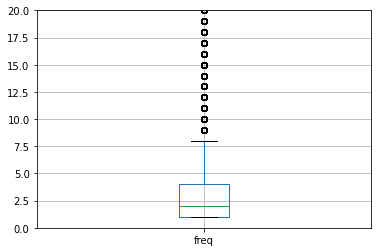

In [42]:
# 6.2 Let us see distribution of visit-frequencies
# 6.2.1  First convert out (pandas Series) to DataFrame
out.name           # This series name will become column name
out.name = "freq"
out = pd.DataFrame(out)   # column name is now 'freq'
# 6.2.2 Draw boxplot now uisng pandas plot function:
out.boxplot(column = 'freq')
plt.ylim((0,20))
plt.show()


In [63]:
# 6.3 Let us verify the above results for at least one customerid
df.loc[df['customerid'] == 1847994 ].nunique()

datetime             76
customerid            1
age                   1
residence_area        1
product_subclass    288
productid           593
quantity             11
salesprice          222
year                  2
month                 4
day                  30
dtype: int64

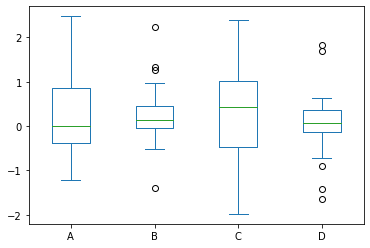

In [56]:
# 6.3.1 Box plots with pandas:
data = np.random.randn(25, 4)
dfx = pd.DataFrame(data, columns=list('ABCD'))
dfx.plot.box();

### Q6

In [53]:
# 7 (Q6): What are total spending per customer
#    Sol: Group by customerid and sum up purchases

# 7.1 First create a new column 'purchase'
df['purchase'] = df['quantity'] * df['salesprice']

# 7.1.1 Now calculate total purchases per customer
out = df.groupby(['customerid'])['purchase'].sum().sort_values(ascending = False)

# 7.1.2 out is a pandas Series
out.head()

# 7.1.3 Make out a DataFrame
out = pd.DataFrame(out)

customerid
1622362    355221564
2123851     17797777
2120829     17795024
1970777     14880612
2134819     14843035
Name: purchase, dtype: int32

<Figure size 432x288 with 0 Axes>

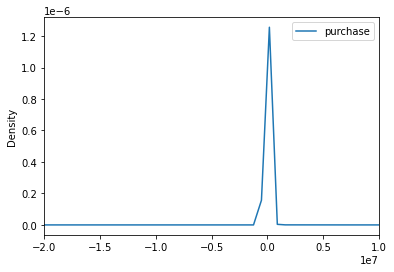

In [54]:
# 7.2 Let us have a density plot of these purchases:

plt.figure() ;
out.plot.kde()     # Pandas kernel denity plot
plt.xlim(-0.2e8, .1e8) ;
plt.show() ;

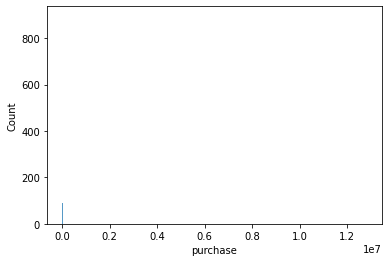

In [55]:
# 7.2.1 seaborn does not plot that well:
out1 = out.sample(n = 5000)
sns.histplot(data = out1, x = 'purchase')
plt.show()

<Figure size 432x288 with 0 Axes>

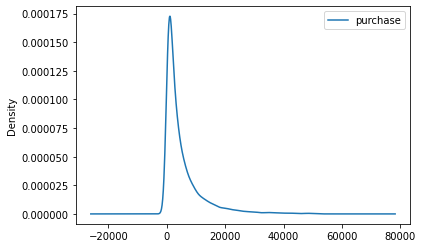

In [56]:
# 7.2.2 So there is an outlier, let us remove
#       it and then plot. We will cutoff at 99th percentile
#       At what value of data 99th percentile occurs?

scoreatpercentile(out.values, per = 99)

# 7.2.3 Here is remaining data

out = out.loc[out['purchase'] < 52135, :]


# 7.2.4 Plot density plot now
plt.figure() ;
out.plot.kde() ;
plt.show() ;

### Q7

In [57]:
# 8. Is there any relationship between freq of visits and total purchases
#    We will use two methods:

## Method 1

# 8.1   First customer-wise visit frequencies
freq = df.groupby('customerid')['datetime'].nunique()
freq.name = "freq"
freq.head()

customerid
1069    4
1113    4
1250    2
1359    1
1823    3
Name: freq, dtype: int64

In [58]:
# 8.2 Then customer-wise purchases:

purchases = df.groupby('customerid')['purchase'].sum()
purchases

customerid
1069         2660
1113         3209
1250         1795
1359          602
1823         6053
            ...  
2179544      6343
2179568       406
2179605      9495
2179643      8461
20002000    90397
Name: purchase, Length: 32266, dtype: int32

In [59]:
# 8.3 Create a dataframe from two continuous series:

freq_purchases = pd.concat([freq,purchases], axis = 1)
freq_purchases.head()

,freq,purchase
customerid,,
1069,4,2660
1113,4,3209
1250,2,1795
1359,1,602
1823,3,6053


In [60]:
# 8.4 So what kind of relationships exist?
#     Answer: Very weak!
freq_purchases.corr()

,freq,purchase
freq,1.000000,0.026599
purchase,0.026599,1.000000


In [61]:
# 8.5 Include only points which are below 99th percentile of purchases
freq_purchases = freq_purchases[freq_purchases['purchase'] < 52135]

In [62]:
# 8.6 Let us revisit relationships
#     Relationship is stronger though not very strong
freq_purchases.corr()


,freq,purchase
freq,1.000000,0.513523
purchase,0.513523,1.000000


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

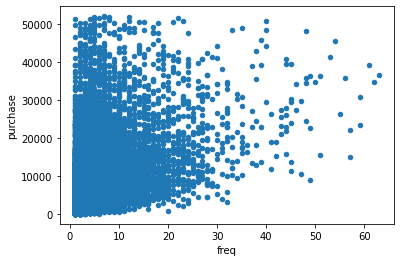

In [63]:
# 8.7 Plot and also annotate now
#     First through pandas plotting methods
plt.figure()
freq_purchases.plot.scatter(x = 'freq', y = 'purchase')
plt.show()

### Q8

In [66]:
# 9. (Q8):  What are average purchases per-customer, per visit
#     Sol: Simple: Gr by customerid,datetime and sum up purchases
#
result = df.groupby(['customerid', 'datetime'])['purchase'].sum()
result.head()

customerid  datetime  
1069        2000-11-01    0
            2000-11-02    0
            2000-11-03    0
            2000-11-04    0
            2000-11-05    0
Name: purchase, dtype: int32

In [67]:
# 9.1 Note that grouping by more than one attribute
#     creates multiindex. Here it has two levels

result.index.get_level_values(0)
result.index.get_level_values(1)

CategoricalIndex([    1069,     1069,     1069,     1069,     1069,     1069,
                      1069,     1069,     1069,     1069,
                  ...
                  20002000, 20002000, 20002000, 20002000, 20002000, 20002000,
                  20002000, 20002000, 20002000, 20002000],
                 categories=[1069, 1113, 1250, 1359, 1823, 2189, 3667, 4282, ...], ordered=False, dtype='category', name='customerid', length=3871920)

DatetimeIndex(['2000-11-01', '2000-11-02', '2000-11-03', '2000-11-04',
               '2000-11-05', '2000-11-06', '2000-11-07', '2000-11-08',
               '2000-11-09', '2000-11-10',
               ...
               '2001-02-19', '2001-02-20', '2001-02-21', '2001-02-22',
               '2001-02-23', '2001-02-24', '2001-02-25', '2001-02-26',
               '2001-02-27', '2001-02-28'],
              dtype='datetime64[ns]', name='datetime', length=3871920, freq=None)

In [68]:
# 9.2 Unentangle it using unstack()
result1 = df.groupby(['customerid', 'datetime'])['purchase'].sum().unstack()
result1.head()

datetime,2000-11-01,2000-11-02,2000-11-03,2000-11-04,2000-11-05,2000-11-06,2000-11-07,2000-11-08,2000-11-09,2000-11-10,...,2001-02-19,2001-02-20,2001-02-21,2001-02-22,2001-02-23,2001-02-24,2001-02-25,2001-02-26,2001-02-27,2001-02-28
customerid,,,,,,,,,,,,,,,,,,,,,
1069,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1113,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1250,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1359,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1823,0,2704,0,0,0,2916,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# 9.3 Find mean, across columns
#     And this our answer to the question
df.groupby(['customerid', 'datetime'])['purchase'].sum().unstack().mean(axis = 1, skipna = True).head()

In [69]:
# 9.4 Let us verify the result for at least one customer
df[df['customerid'] == 1069].groupby('datetime')['purchase'].sum()
(187 + 971 + 922 + 580)/4               # 665


datetime
2000-11-13    187
2001-01-21    971
2001-02-03    922
2001-02-10    580
Name: purchase, dtype: int32

665.0

### Q9

In [70]:
# 10 (Q9):  What are average purchases customer-wise
#          Sol: Gr by customerid and find mean() purchases per id

df.groupby('customerid')['purchase'].mean().sort_values(ascending = False)


customerid
1622362    5.464947e+06
2134819    3.710759e+06
2123851    1.617980e+06
2139296    1.538240e+06
2120829    1.482919e+06
               ...     
1495300    9.000000e+00
1521498    9.000000e+00
848442     9.000000e+00
1456431    8.000000e+00
2149516    8.000000e+00
Name: purchase, Length: 32266, dtype: float64

### Q10

In [ ]:
## 11. Q9
# 11.1 Determine customer-wise, product_subclass preference?
#     We will define preference as no of different datetimes purchased.
#     All purchases of a product_subclass on one date count to one.

result = df.groupby(['customerid', 'product_subclass'])['datetime'].nunique().sort_values(ascending= False)
result.head()

# 11.2 Just to extract result for one customer from this multiindex, use
#      index.get_level_values()....rather complicated but works
#  Ref: https://stackoverflow.com/questions/17921010/how-to-query-multiindex-index-columns-values-in-pandas
result.loc[result.index.get_level_values('customerid')  == 1740653, :]


# 11.3 But if preference means by quantity, then solution is:
df.groupby(['customerid', 'product_subclass'])['quantity'].sum().sort_values(ascending= False)

### Q11

In [71]:
# 12 (Q10): Basket of purchases:
#            Variety of purchases made per customer, Productid wise

df.groupby(['customerid'])['productid'].nunique().sort_values(ascending = False)


customerid
20459      1034
2112589     793
2112596     722
2113579     684
1847994     593
           ... 
2156385       1
1720280       1
218498        1
1923100       1
1783001       1
Name: productid, Length: 32266, dtype: int64

### Q12

In [72]:
# 13  Which product_class brings most revenue
#        Sol: Group by product_subclass and add quantity * salesprice

# 13.1 Here is the solution:
df.groupby(['product_subclass'])['purchase'].sum()


product_subclass
100101     199457
100102    2140857
100103     446425
100104     104410
100105      48262
           ...   
780506       8203
780507        250
780508       8031
780509       1170
780510     116813
Name: purchase, Length: 2012, dtype: int32

### Q13

In [73]:
# 13.2 (Q12): Which product_subclass is popular that is
#             most customers buy?
df.groupby(['product_subclass'])['customerid'].nunique().sort_values(ascending=False)


product_subclass
100205    9694
500201    7533
130315    7410
110401    6587
110217    6489
          ... 
760910       1
550104       1
510306       1
730610       1
500348       1
Name: customerid, Length: 2012, dtype: int64

### Exercise questions


In [74]:
## Not solved. Students to solve these
# 13.3 (Q14): Age wise purchases average. Which age group max purchases
#             Just group by age

# 13.4 (Q15): Residence area wise purchasing capacity
#             Just group by residence area wise


# 13.5 (Q16)  Per visit/per transaction avg money spent


# 14   (Q17): Distribuiton of age groups with residence_area
#             Same as:  table(d12$age, d12$residence_area)

# 15.  (Q18)    What is the distribution of customers, age-wise


### Q19

In [ ]:

# 16. (Q18) Is there a relationship between 'age' and 'residence_area'
#           We will calculate ch-square statistics
#           An often quoted guideline for the validity of chi-square calculation
#           is that the test should be used only if the observed and expected
#           frequencies in each cell are at least 5.

# 16.1 Return values are: chi2 statistic, p-value, degrees-of-freedom, expected-freq
chi2_contingency(pd.crosstab(df.age, df.residence_area))     # p-value = 0
# OR
# 16.2
chi2, p_value, dof, expeFreq = chi2_contingency(pd.crosstab(df.age, df.residence_area))
p_value



# 17. Mosiac plot of contingency table
#     At a glance view of deviation from expected freq
# statistic=True  will give colors to the plot. If the tile has a freq
#   is more than 2 standard deviation from the expected value
#    color will go from green to red (for positive deviations, blue otherwise)
#     and will acquire an hatching when crosses the 3 sigma.
fig = plt.figure(figsize = (10,10))     # Set figure size
ax = fig.add_subplot(111)               # Add one subplot
mosaic(df, ['age', 'residence_area'],
       ax = ax,
       statistic = True
       )
plt.show()


# 18   t-test IS there any significant difference in avg spending
#        age-wise, say, between ages 'A' and 'B'
#   Steps:
#        1. Extract spending data for two ages
#        2. Discover 99th percentile points for each
#        3. Remove outliers
#        4. Perform t-test

# 18.1 'purchase' data for age = 'A'
a = df.loc[df['age'] == 'A', 'purchase']
len(a)              # 30068

# 18.2 'purchase' data for age = 'B'
b = df.loc[df['age'] == 'B', 'purchase']
len(b)              # 66427

# 18.3 Conduct t-test now. Are the means of two purchases equal?
_, pvalue = ttest_ind( a, b, axis=0)
pvalue      # 0.18781 So no difference in purchase mean

# 18.4 Let us remove few outliers and then again perform t-test
#      What is the 99th percentile in each case
scoreatpercentile(a, per = 99)             # 2558
scoreatpercentile(b, per = 99)             # 3029

# 18.5 Extract from 'a' & 'b' values other than outlers
a= a[a<2558]
b = b[b<3029]
len(a)        # 29767
len(b)        # 65762

# 18.6 Perform t-test now:
# 18.7 Removing outliers drastically alters the conclusion
_, pvalue = ttest_ind( a, b, axis=0)
pvalue             # 3.060e-42



In [ ]:
#################### I am done ##########################################